In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
data = pd.read_pickle('./DataSets/mnist.pkl')

The original 1-channel image looks like:


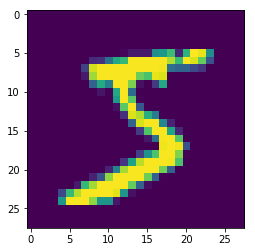

In [3]:
print('The original 1-channel image looks like:')
plt.imshow(np.array(data[0][0])[0].reshape(28,28))
plt.show()

In [4]:
print('label:',data[0][1][0])

label: 5


### Forward Propagation Process Functions

In [5]:
# initialize weights
def initWeights(layersSizeList): # when len(input) = k, then return (k-1) Ws and (k-1) bs
    np.random.seed(0)
    Ws = []
    bs = []
    for i in range(len(layersSizeList)-1):
        W = np.random.randn(layersSizeList[i+1], layersSizeList[i])*np.sqrt(2/layersSizeList[i])
        b = np.random.randn(layersSizeList[i+1],1)
        Ws.append(W)
        bs.append(b)
    return [Ws,bs]

# single layer forward
def singleForward(prevA, W, b):
    Z = W.dot(prevA)+b.dot(np.ones(prevA.shape[1]).reshape(prevA.shape[1],1).T)
    cache = [prevA, W, b]
    return [Z,cache]

# single forward with different configurable active functions
def actSigmoid(Z):
    Z_safe = np.clip(Z, -500, 500)
    return [1/(1+np.exp(-Z_safe)),Z]

def actRelu(Z):
    Z_ = Z.copy()
    Z_[Z_<0] = 0
    return [Z_,Z]

def actSoftMax(Z):
    Z_ = np.clip(Z,-500,1000)
    return [np.exp(Z_)/(np.sum(np.exp(Z_),axis=0)), Z]

def actTanh(Z):
    A = np.tanh(Z)
    return [A, Z]

# do a single forward propagation for a single dense layer
def actForward(prevA, W, b, act_f):
    [Z, cache] = singleForward(prevA, W, b)
    if act_f==0:
        # do relu
        [A, actCache] = actRelu(Z)
        Caches = [cache, actCache] #Caches = [[prevA, W, b],Z]
        return [A, Caches]
    elif act_f == 1:
        # do sigmoid
        [A,actCache] = actSigmoid(Z)
        Caches = [cache, actCache]
        return [A,Caches]
    elif act_f == 2:
        # do tanh
        [A,actCache] = actTanh(Z)
        Caches = [cache, actCache]
        return [A,Caches]
    elif act_f == 3:
        # do softmax
        [A,actCache] = actSoftMax(Z)
        Caches = [cache, actCache]
        return [A,Caches]
    elif act_f == 4:
        actCache = Z.copy()
        A = Z.copy()
        Caches = [cache, actCache]
        return [A, Caches]

# forward propagation for a multiple levels dense model
def layersForward(batchX, weights, layersSizeList, act_f, loss):
    L = len(layersSizeList)
    X = batchX.copy()
    layersCaches = []
    for i in range(0,L-2):
        A_prev = X
        [A, Caches] = actForward(A_prev, weights[0][i], weights[1][i], act_f)
        X = A
        layersCaches.append(Caches)  #Caches = [linearcache, actCache]
    # last layer:
    AL = np.array([])
#     print(len(layersCaches))
    if loss == 0:
        [AL, Caches] = actForward(X, weights[0][L-2], weights[1][L-2], 3)
        layersCaches.append(Caches)
    elif loss == 1:
        [AL, Caches] = actForward(X, weights[0][L-2], weights[1][L-2], 4)
        layersCaches.append(Caches)
#     print(len(layersCaches))
    return [AL, layersCaches]

# available loss functions: MSE, Cross-Entropy, Cross-Entropy-with-Regular
def MSEloss(AL, Y):
    m = len(Y)   # m for batch size
    # least square:
    loss = 0
    for i in range(m):
        singleLoss = 0
        singleLabel = int(Y[i])
        singleResult = AL[:,i]
#         print(singleResult, singleLabel)
        for j in range(AL.shape[0]):
            if j == singleLabel: 
                singleLoss += (singleResult[j]-1)**2
            else: 
                singleLoss += (singleResult[j])**2
#         print(singleLoss)
        loss += singleLoss
    loss = 1/m*loss
    return loss

def CrossEntropyLoss(AL, Y):
    m = len(Y)
    loss = 0
    for i in range(m):
        singleLoss = 0
        singleLabel = int(Y[i])
        singleResult = AL[:,i]
        for j in range(AL.shape[0]):
            if j == singleLabel:
                loss += np.log(singleResult[j]+1e-5)
    loss = 1/m * (-1) * loss
    return loss

def CrossEntropyLossWithRegular(AL, Y, W1, W2, W3):
    m = len(Y)
    loss = 0
    for i in range(m):
        singleLoss = 0
        singleLabel = int(Y[i])
        singleResult = AL[:,i]
        for j in range(AL.shape[0]):
            if j == singleLabel:
                loss += np.log(singleResult[j]+1e-5)
    loss = 1/m * (-1) * loss
    loss += np.sum(W1*W1)
    loss += np.sum(W2*W2)
    loss += np.sum(W3*W3)
    return loss

### Backward Propagation Process Functions

In [6]:
# linear backward function for different act-layers or dense layers
def singleBackward(dZ, cahce):
    # decode
    [prevA, W, b] = cahce
    m = prevA.shape[1]
#     print('dZ',dZ)
    dW = 1/m*dZ.dot(prevA.T)
    db = 1/m*np.sum(dZ, axis=1)
    db = db.reshape(db.shape[0],1)
#     print('db.shape:',db.shape)
    dprevA = W.T.dot(dZ)
    return [dprevA, dW, db]

# backward with active functions
def sigmoidBackward(dA, Z):
    A = actSigmoid(Z)[0]
    Z_ = np.multiply(A,(np.ones_like(A)-A))
    dZ = np.multiply(dA,Z_)
    return dZ
    
def reluBackward(dA, Z):
    Z_ = Z.copy()
    Z_[Z_<0]=0
    Z_[Z_!=0]=1
    dZ = np.multiply(dA,Z_)
    return dZ

def tanhBackward(dA, Z):
    A = actTanh(Z)[0]
    Z_ = np.ones_like(A) - A*A
    dZ = np.multiply(dA,Z_)
    return dZ

def softMaxAndCrossEntropyBackward(Z, Y):
    res = []
    for i in range(Z.shape[1]):
        yi = []
        singleLabel = int(Y[i])
        for j in range(Z.shape[0]):
            if j == singleLabel: 
                yi.append(1)
            else:
                yi.append(0)
        yi = np.array(yi)
        ai = np.array(np.squeeze(Z[:,i]))
        pi = actSoftMax(ai)[0]
        res.append(np.squeeze(pi-yi))
    dZ = np.array(res).T
    return dZ

def identityAndMSEBackward(Z, Y):
    res = []
    for i in range(Z.shape[1]):
        yi = []
        singleLabel = int(Y[i])
        for j in range(Z.shape[0]):
            if j == singleLabel: 
                yi.append(1)
            else:
                yi.append(0)
        yi = np.array(yi)
        ai = np.array(np.squeeze(Z[:,i]))
        res.append(np.squeeze(ai-yi))
    dZ = np.array(res).T
    return dZ

def actBackward(dA, cache, act_f):
    # cache = [linearCache, actCache] where linearCache = [prevA, W, b], actCache = Z
    [linearCache, actCache] = cache
    dZ = np.array([])
    if act_f == 0:
        # do relu back
        dZ = reluBackward(dA, actCache)
    elif act_f == 1:
        # do sigmoid back
        dZ = sigmoidBackward(dA, actCache)
    elif act_f == 2:
        dZ = tanhBackward(dA, actCache)
    [dprevA, dW, db] = singleBackward(dZ, linearCache)
    return [dprevA, dW, db]

# multiple levels backward model
def layersBackward(AL, Y, layersCaches, act_f, loss):
    # layersCaches = [[[prevA, W, b](linear),Z(act)](layer1),..]
    gradients = []
    [lastLinearCache, lastActCache] = layersCaches.pop()
    dZlast = np.array([])
    if loss == 0:
        dZlast = softMaxAndCrossEntropyBackward(lastActCache, Y)
    elif loss == 1:
        dZlast = identityAndMSEBackward(lastActCache, Y)
#         print(dZlast)
    [dprevALast, dWLast, dbLast] = singleBackward(dZlast, lastLinearCache)
    gradients.append([dWLast, dbLast])
    dA_prev = dprevALast
    for i in range(len(layersCaches)):
        Caches = layersCaches.pop()
        [dprevAthis, dW, db] = actBackward(dA_prev, Caches, act_f)
        dA_prev = dprevAthis
        gradients.append([dW, db])
    return gradients

def regularTuningGradient(lamda, W):
    res = []
    for i in range(W.shape[1]):
        singleVector = W[:,i]
        res.append(singleVector)
    return np.array(res).T

### Validate Function

In [8]:
# validation function applied in validation dataset
def test(dataset, labels, weights, layersSizeList, act_f, loss):
    count = 0
    for dataPointIndex in range(len(dataset)):
        dataPoint = dataset[dataPointIndex]
        [AL, _] = layersForward(dataPoint.reshape(dataPoint.shape[0],1), weights, layersSizeList, act_f, loss)
        if np.argmax(AL)== int(labels[dataPointIndex]):
            count+=1
    return count/len(dataset)

### Training Function

In [9]:
def batchTrain(X, Y, weights, layersSizeList, act_f, loss):
    [AL, layersCaches] = layersForward(X, weights, layersSizeList,act_f, loss)
#     print(AL.shape)
    if loss == 0:
        loss_ = CrossEntropyLoss(AL, Y)
    elif loss == 1:
        loss_ = MSEloss(AL, Y)
    gradients = layersBackward(AL, Y, layersCaches, act_f, loss)
    return [loss_, gradients]

def train(dataset, labels, vdataset, vlabels,layersSizeList, learningRate, batchSize, epochNumber, act_f, loss, regu):
    weights = initWeights(layersSizeList)
    lossHistory = []
    accHistory = []
    for epoch in range(epochNumber):
        batchNumber = len(dataset) // batchSize
        lossEpoch = 0
        for itr in range(batchNumber):
#         for itr in range(40):
            Xbatch = np.array(dataset[itr*batchSize:itr*batchSize+batchSize]).T
            Ybatch = list(np.array(labels[itr*batchSize:itr*batchSize+batchSize]))
            [loss_, gradients] = batchTrain(Xbatch, Ybatch, weights, layersSizeList, act_f, loss)
            lossEpoch = float(loss_)
            # update weights
            for i in range(len(gradients)):
                [WGradient, bGradient] = gradients.pop()
                weights[0][i] -= learningRate*WGradient
                weights[1][i] -= learningRate*bGradient
#             if regu == 1:
#                 weights[0][i] -= learningRate*regularTuningGradient(0.01, weights[0][i])
#                 weights[1][i] -= learningRate*regularTuningGradient(0.01weights[0][i])
        lossHistory.append(float(lossEpoch))
        accHistory.append(test(vdataset, vlabels, weights, layersSizeList, act_f,loss))
        
    return lossHistory, accHistory

In [33]:
time1 = time.time()
his0 = train(data[0][0], data[0][1], data[1][0], data[1][1],  [784, 50, 10], 0.01, 50, 3, 0, 0, 0)
time2 = time.time()

In [34]:
time3 = time.time()
his1 = train(data[0][0], data[0][1], data[1][0], data[1][1],  [784, 50, 10], 0.01, 100, 3, 0, 0, 0)
time4 = time.time()

In [36]:
print(time2-time1)
print(time4-time3)

9.24242377281189
8.361682176589966


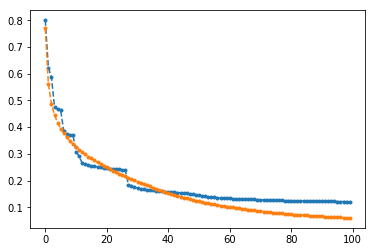

In [24]:
# see the loss
plt.plot(his0[0],'.--')
plt.plot(his1[0],'.--')
plt.show()

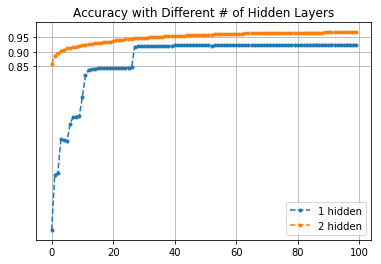

With 100 neurons, act function: relu,
30 epochs, learning rate = 0.1, batch size = 50, 
1 hidden layer, loss: Cross Entropy,
Without regularization


In [25]:
#plotting different comparisions
plt.plot(his0[1],'.--')
plt.plot(his1[1],'.--')
plt.yticks(np.arange(0.85, 0.96, step=0.05))
plt.legend(['1 hidden', '2 hidden'])
plt.grid()
plt.title('Accuracy with Different # of Hidden Layers')
plt.show()
print('With 100 neurons, act function: relu,\n30 epochs, learning rate = 0.1, batch size = 50, \n1 hidden layer, loss: Cross Entropy,\nWithout regularization')